# Imports, load data, etc

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


from scipy.stats import gaussian_kde, norm, genextreme

import pickle
import numpy as np
import sys

from mcmceva import plot, stats
from common import *
from adjustText import adjust_text

# import arviz as az

set_rcparams()


%config InlineBackend.figure_format = 'retina'

In [4]:
np.seterr("warn")

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [5]:
directories = load_directories()
project = load_anduryl_project()

In [6]:
# Load AM Borgharen

# Load discharge measurements
afvoermetingen = pd.read_csv(directories["meuse_measurements"] / "discharge_measurements.csv", index_col=[0])
afvoermetingen.index = pd.to_datetime(afvoermetingen.index)

# Get annual maxima
ams = {
    loc: stats.get_annual_maxima(column + np.linspace(0, 1e-3, len(column)))
    for loc, column in afvoermetingen.items()
}
ams["Borgharen"] = ams["Maas, Borgharen"]
ams["Roermond"] = ams["Maas, Venlo"]
ams["Gennep"] = ams["Maas, Venlo"]

# Meta

In [7]:
Nevents = 10000
# As the number of samples is equal, the (empirical) exceedance probabilities are as well
# We generate them on beforehand, and pick the relevant ones for plotting
exc_probs = stats.convert_freq_prob(1.0 / stats.calc_return_period_am(np.arange(Nevents)))
int_exc_prob = np.logspace(np.log10(exc_probs[0]), np.log10(exc_probs[-1]), 200, base=10)
# Find nearest
idx = np.unique([np.argmin(np.absolute(exc_probs - ep)) for ep in int_exc_prob])
exc_probs = exc_probs[idx]

experts = [
    "ExpA",
    "ExpB",
    "ExpC",
    "ExpD",
    "ExpE",
    "ExpF",
    "ExpG",
    "GL",
    "EQ",
]  # project.experts.get_exp("actual")

# Plot overview of curves

In [8]:
def plot_expert_estimates_pdf(ax, location, expert, return_period: list):

    # Plot the expert estimates
    for rp in return_period:

        item = f"{location.split(',')[1].strip()}T{rp}"
        estimates = project.assessments.estimates[expert][item].estimates

        expname = expert if expert in project.results else "GL"
        plotdata = project.results[expname].get_plot_data(experts=[expert], items=[item])[(item, expert)]
        
        # Don't plot the outer edges, assign a minimum required probability density for plotting
        min_edge_pd = 1e-5
        idx = np.where(plotdata.pdf_y > min_edge_pd)[0]
        idx = np.arange(idx[0], idx[-1], 1)

        x = np.interp(np.exp(plotdata.pdf_y[idx]), np.exp([0, plotdata.pdf_y.max()]), [1 / rp, 0.2 / rp])
        ax.plot(x, plotdata.pdf_x[idx], color="k", lw=0.75)
        ax.plot([1 / rp, 1 / rp], [plotdata.pdf_x[idx.max()], plotdata.pdf_x[idx.min()]], color="k", lw=0.4)
        ax.plot(
            [1 / rp] * len(plotdata.estimates), list(plotdata.estimates.values()), color="k", marker="x", ls="", ms=3
        )



# Article figure

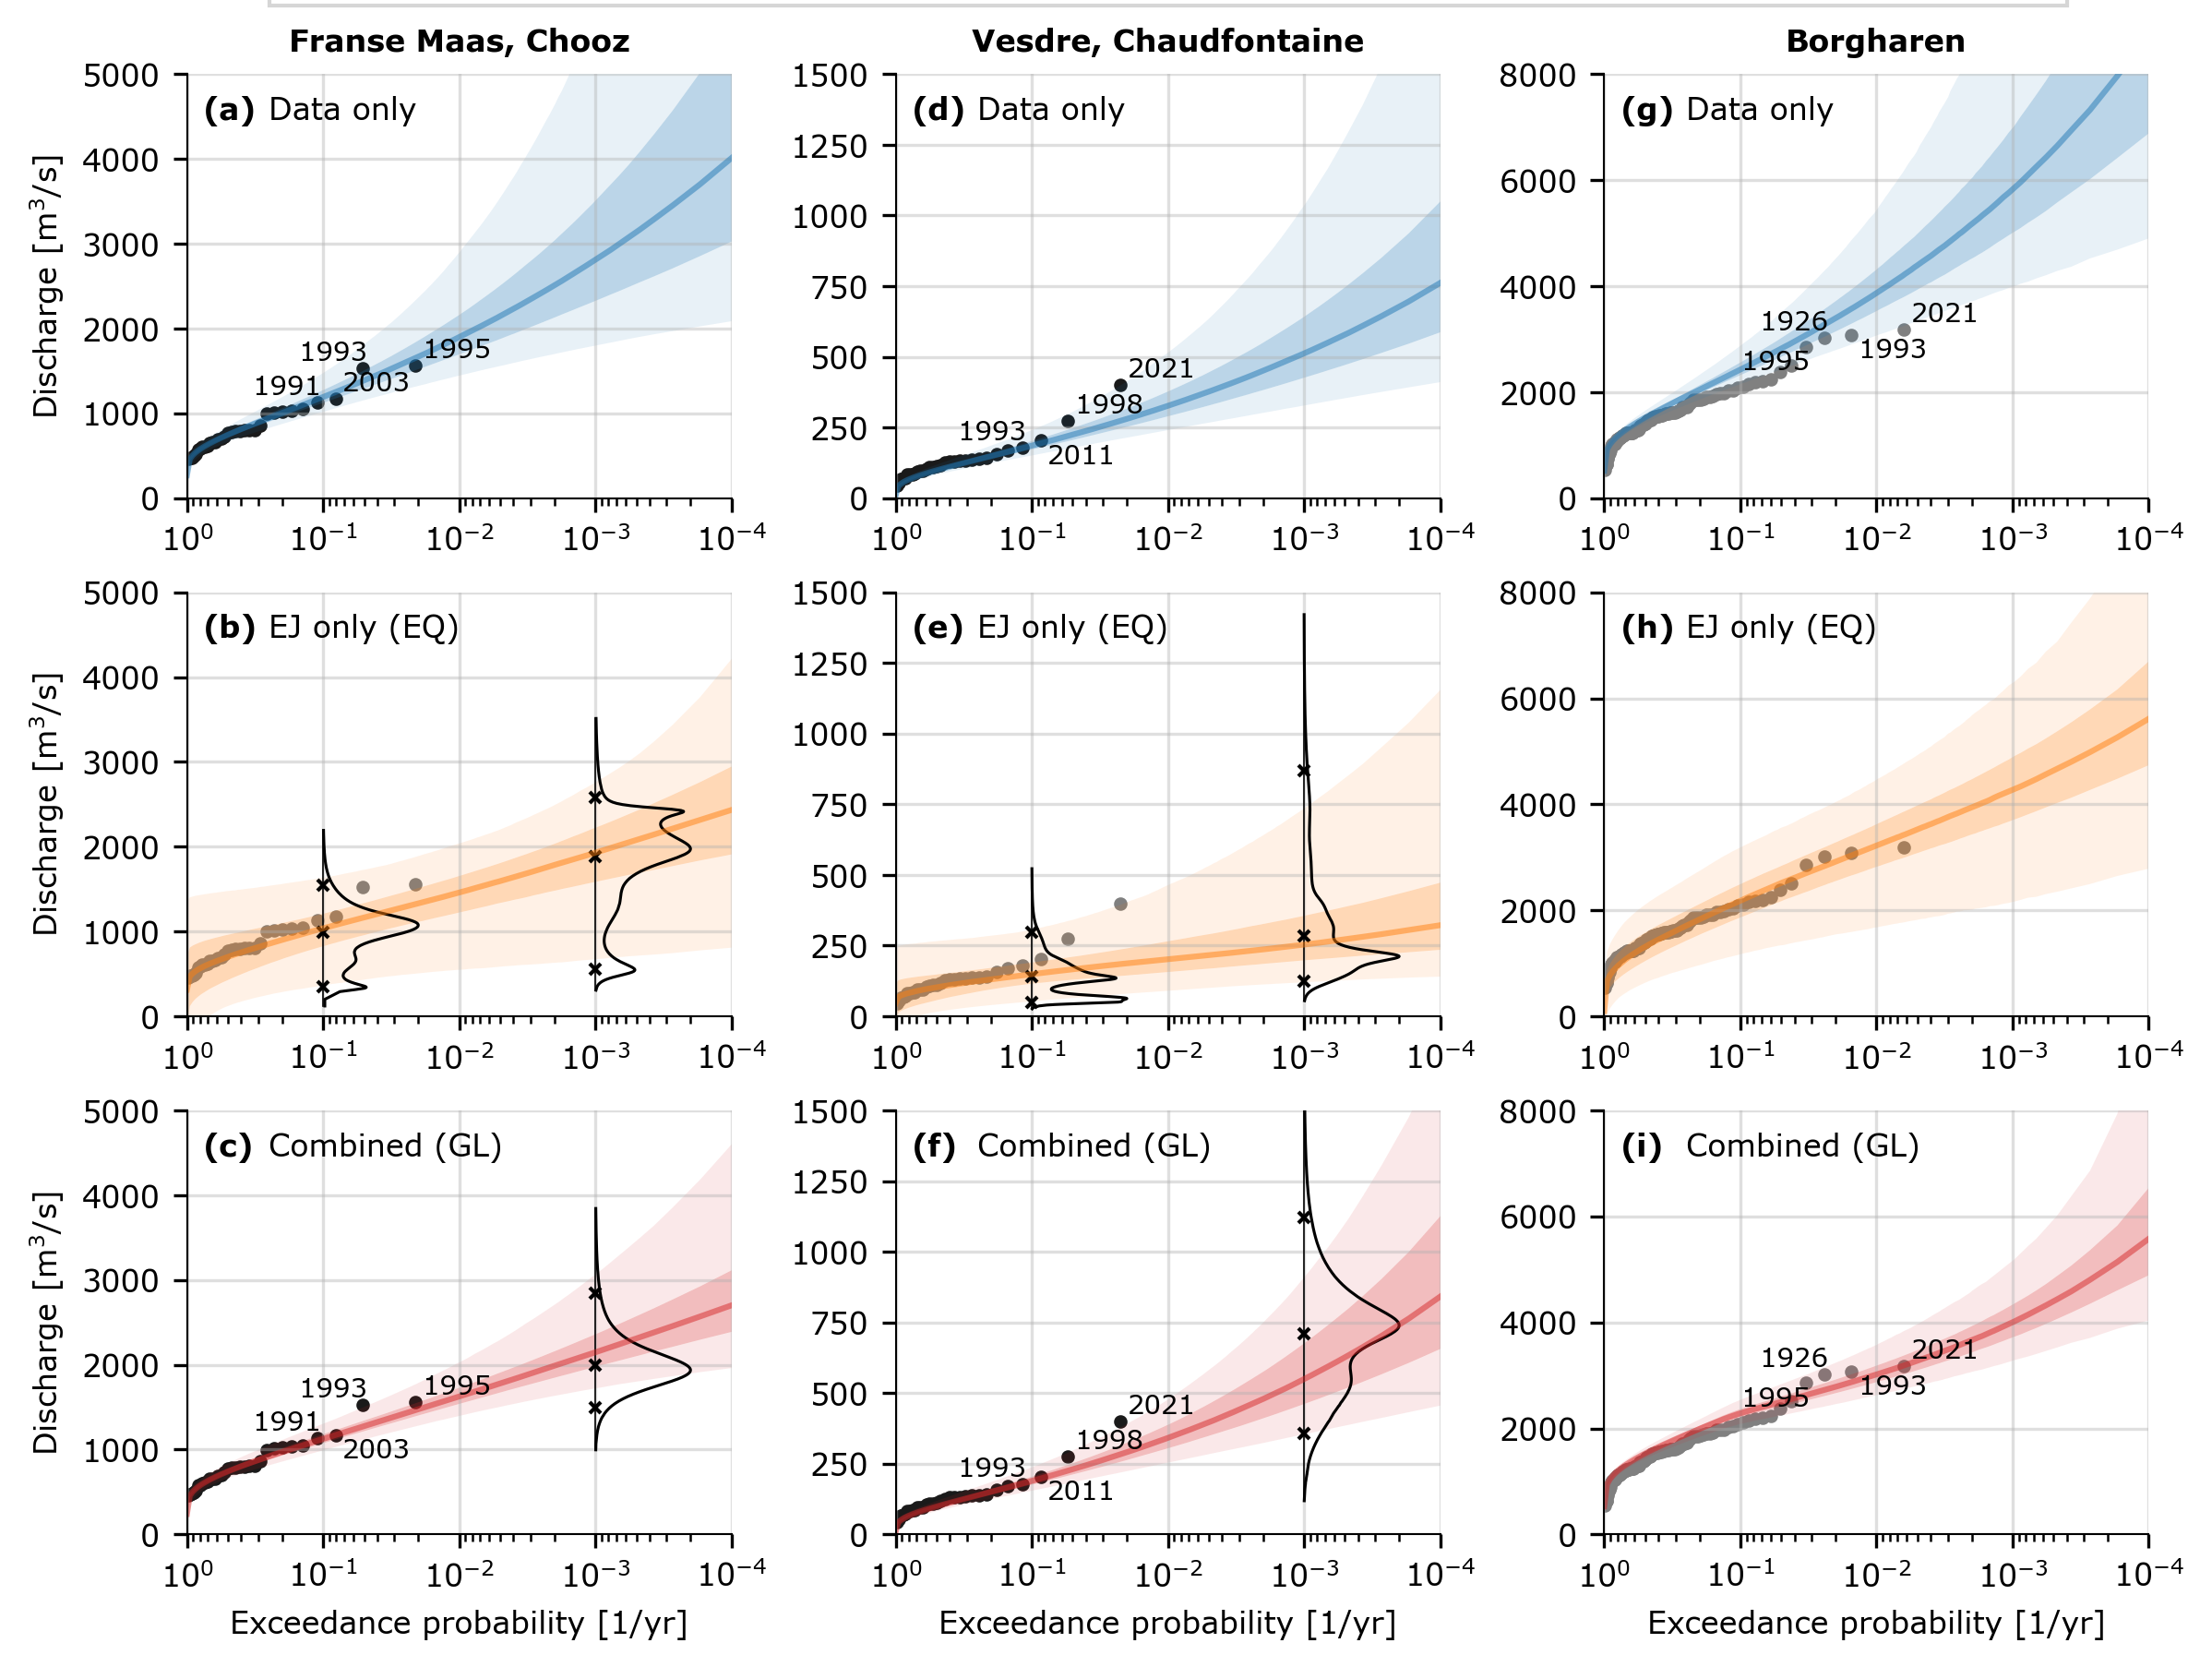

In [10]:
figwidth, figheight = 20 / 2.54, 15 / 2.54
fig, axss = plt.subplots(figsize=(figwidth, figheight), ncols=3, nrows=3, constrained_layout=True)
### Borgharen data, EJ [EQ], Comb [GL]

locations = ["Franse Maas, Chooz", "Vesdre, Chaudfontaine", "Borgharen"]

modes = ["obs", "ej", "both"]
dms = [None, "EQ", "GL"]
colors = ["C0", "C1", "C3"]
annotations = ["Data only", "EJ only (EQ)", "Combined (GL)"]
ymaxs = [5000, 1500, 8000]
percentiles = np.array([2.5, 25.0, 50.0, 75.0, 97.5])

for location, ymax, axs in zip(locations, ymaxs, axss.T):

    for mode, dm, ax, color, annotation in zip(modes, dms, axs, colors, annotations):

        if location == "Borgharen":
            fp = directories["sampledir"] / location /  f"{location}_{mode}{'' if mode == 'obs' else '_'+dm}.csv"
            data = pd.read_csv(fp, index_col=[0])
            exc_probs = data.index.to_numpy()
            data = data.loc[:, percentiles.astype(str)].to_numpy()
            
        else:
            fp = directories["sampledir"] / f"{location}_{mode}{'' if mode == 'obs' else '_'+dm}.pkl"
            with open(fp, 'rb') as f:
                trace = pickle.load(f)

            data = plot.calc_percentiles(
                trace, dist=genextreme, pps=percentiles/100, exc_probs=exc_probs
            )

            if mode != "obs":
                plot_expert_estimates_pdf(
                    ax, location, dm, return_period=[10, 1000] if mode == "ej" else [1000]
                )

        ax.set(
            xscale="log",
            ylim=(0, ymax),
            title=location if mode == "obs" else "",
            xlabel="Exceedance probability [1/yr]" if mode == "both" else "",
            xlim=(1, 0.0001),
            ylabel=f"Discharge [m$^3$/s]" if location.startswith("Franse") else "",
        )
        ax.annotate(
            annotation,
            (0.15, 0.95),
            fontweight="normal",
            fontsize=8,
            xycoords="axes fraction",
            va="top",
            ha="left",
        )

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.grid()

        texts = plot.add_observations(
            ax,
            ams[location].sort_values(ascending=False),
            4 if mode != "ej" else 0,
            plot_params=dict(s=25, color="0.5" if mode == "ej" or location == 'Borgharen' else "0.1", label=None),
        )
        if mode != "ej":
            adjust_text(texts, ax=ax)

        plot.plot_percentiles_filled(ax, exc_probs, data, color=color, label=False)
        
plot.add_panel_letters(axss, pos=(0.03, 0.95), fmt='({})', transpose=True)

# fig.subplots_adjust(top=0.2)

ax = axss[0, 1]
ax.plot([], [], color='grey', alpha=0.8, label='Median')
ax.fill([], [], color='grey', alpha=0.4, label="50% uncertainty interval")
ax.fill([], [], color='grey', alpha=0.2, label="95% uncertainty interval")

ax.plot([], [], color='C0', alpha=0.8, label=annotations[0])
ax.plot([], [], color='C1', alpha=0.8, label=annotations[1])
ax.plot([], [], color='C3', alpha=0.8, label=annotations[2])

ax.scatter([], [], marker=".", **dict(s=25, label="Observations", color="0.1"))
ax.scatter([], [], marker=".", **dict(s=25, label="Observations for reference (i.e., not used for fitting)", color="0.5"))

leg = ax.legend(bbox_to_anchor=(0.5, 1.5), ncol=3, loc='upper center')
leg.set_in_layout(False)

# fig.savefig(directories["figuredir"] / f"Exceedance frequency curves.pdf", bbox_extra_artists=(leg,), bbox_inches='tight', pad_inches=0.01)

# T1000 estimates

In [16]:
grade = pd.read_csv(directories["datadir"] / "Other" / "GRADE_statistics_Borgharen.csv")
grade

,Mean,Exc prob,StDev
0,1440,0.083333,85.0
1,1970,0.033333,115.0
2,2300,0.016667,145.0
3,2600,0.008333,207.5
4,2970,0.003333,270.0
5,3220,0.001667,287.5
6,3520,0.000667,285.0
7,3700,0.000333,295.0
8,3910,0.000133,350.0
9,4020,0.000083,392.5


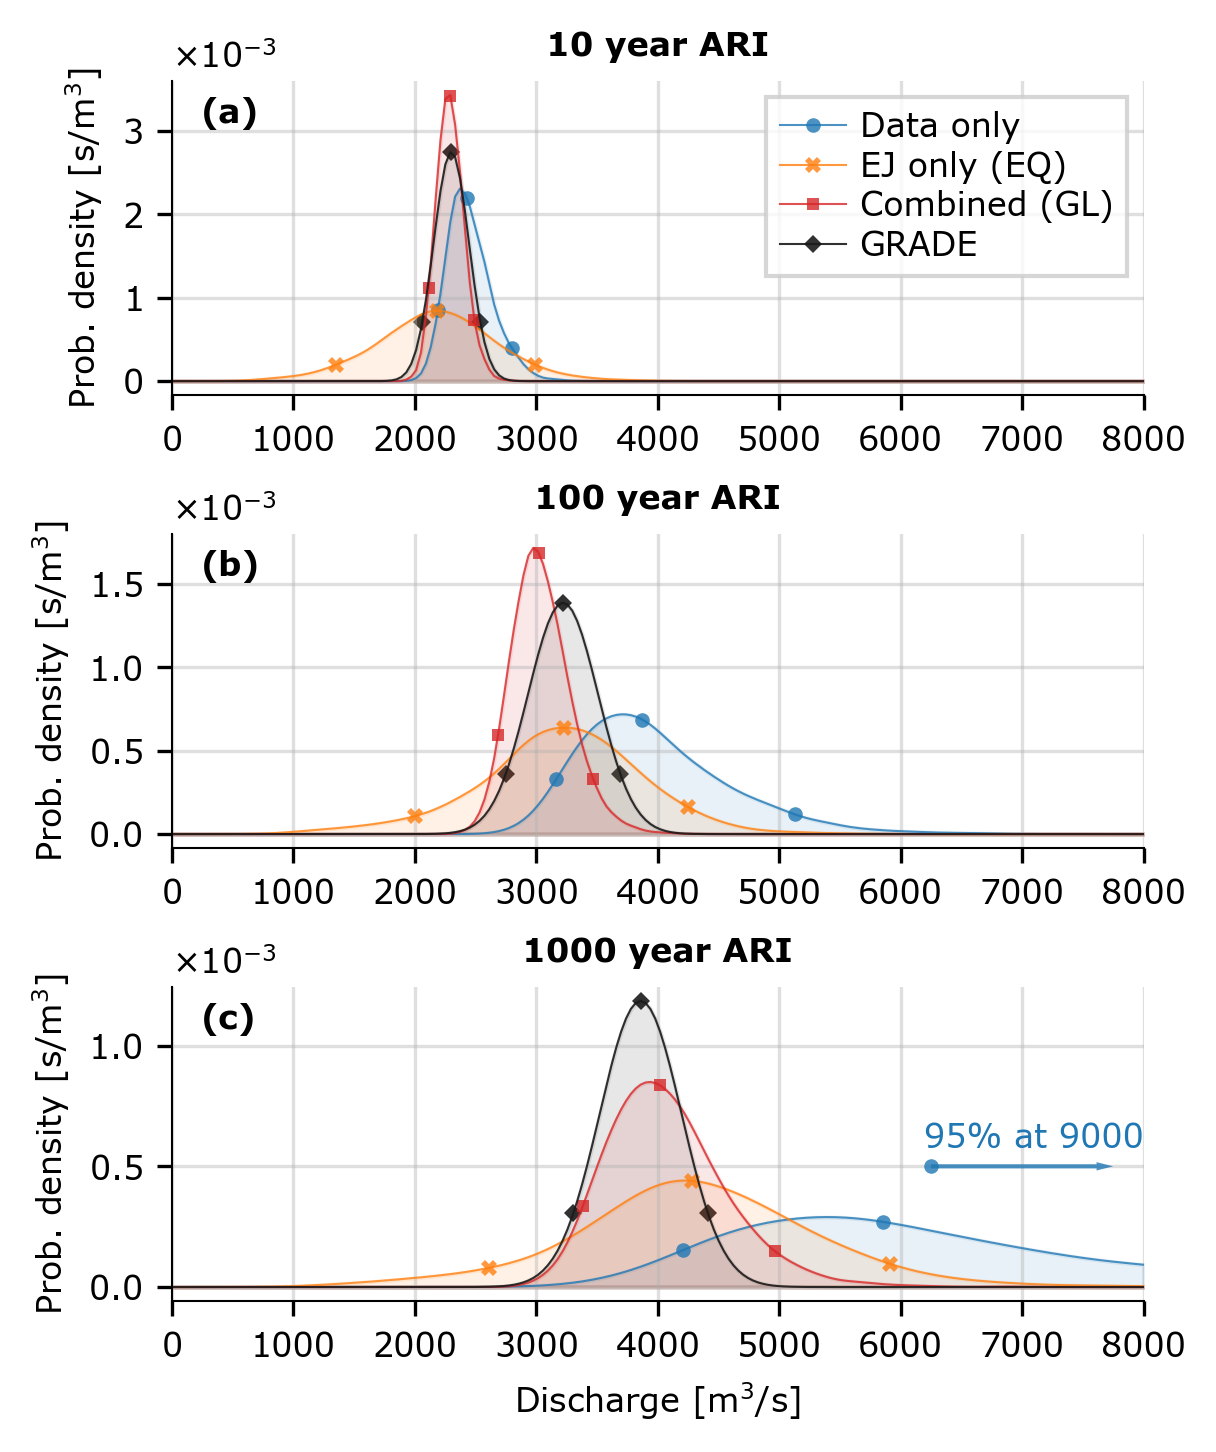

In [19]:
import matplotlib as mpl

msdict = {".": 7, "s": 3, "X": 4, "D": 3}

plotargs = {
    "obs": dict(color="C0", lw=0.5, ls="-", alpha=0.8, label="Data only"),
    "ej": dict(color="C1", lw=0.5, ls="-", alpha=0.8, label="EJ only (EQ)"),
    "both": dict(color="C3", lw=0.5, ls="-", alpha=0.8, label="Combined (GL)"),
    "borgharen": dict(color=".1", lw=0.5, ls="-", alpha=0.9, label="GRADE"),
}

# ### Borgharen data, EJ [EQ], Comb [GL]

fig, axs = plt.subplots(figsize=(10 / 2.54, 12 / 2.54), constrained_layout=True, nrows=3)

location = "Borgharen"

modes = ["obs", "ej", "both"]
dms = [None, "EQ", "GL"]
markers = [".", "X", "s"]


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


qgrid = np.linspace(0, 8000, 200)

mf = mpl.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((1, 2))

rps = ["T10", "T100", "T1000"]

for rp, ax in zip(rps, axs.T):

    for mode, dm, color, annotation, marker in zip(modes, dms, colors, annotations, markers):

        # Load data from npy saved array
        col = np.load(
            directories["sampledir"] / location / rp / f"{mode}{'' if mode == 'obs' else '_'+dm}.npy"
        )
        
        # Determine kde step based on 98% range
        xstep = np.diff(np.quantile(col, [0.01, 0.99]))[0] / 20

        ykde = kde_scipy(col, qgrid, xstep)
        args = plotargs[mode].copy()
        del args["label"]
        ax.plot(qgrid, ykde, **args)
        ps = np.quantile(a=col, q=[0.05, 0.5, 0.95])

        ax.plot([], [], **plotargs[mode], marker=marker, ms=msdict[marker], mew=0)

        ax.plot(
            ps,
            np.interp(ps, qgrid, ykde),
            marker=marker,
            color=plotargs[mode]["color"],
            ls="",
            ms=msdict[marker],
            alpha=0.8,
            mew=0,
        )
        ax.fill_between(x=qgrid, y1=ykde, alpha=0.1, color=plotargs[mode]["color"])

        ax.set(
            xlabel="Discharge [m$^3$/s]" if location == "Gennep" else "",
            ylabel="Prob. density [s/m$^3$]",
            xlim=(0, 8000),
            title=f"{rp[1:]} year ARI",
        )

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid()

        xmax = ax.get_xlim()[1]
        if ps[-1] > xmax:
            ax.text(
                xmax,
                0.55e-3,
                f"95% at {round(ps[-1], -3):.0f}",
                color=plotargs[mode]["color"],
                ha="right",
                va="bottom",
            )
            ax.plot(
                xmax - 1750, 0.5e-3, marker=".", color=plotargs[mode]["color"], ls="", ms=7, mew=0, alpha=0.8
            )
            ax.annotate(
                "",
                xytext=(xmax - 1750, 0.5e-3),
                xy=(xmax - 250, 0.5e-3),
                arrowprops=dict(color="C0", width=1, headwidth=2, headlength=4, lw=0, alpha=0.8),
            )

        ax.yaxis.set_major_formatter(mf)

    # Plot GRADE statistics
    borgharen_mean = np.interp(
        np.log(1.0 / int(rp[1:]) / 6), np.log(grade["Exc prob"])[::-1], grade["Mean"][::-1]
    )
    borgharen_scale = np.interp(borgharen_mean, grade["Mean"], grade["StDev"])

    mode = "borgharen"
    borgharen_norm = norm(loc=borgharen_mean, scale=borgharen_scale)
    yborg = borgharen_norm.pdf(x=qgrid)
    ax.plot(qgrid, yborg, **{k: v for k, v in plotargs[mode].items() if k not in ["label"]})
    ax.fill_between(x=qgrid, y1=yborg, alpha=0.1, color=plotargs[mode]["color"], zorder=-10)
    qs = [0.05, 0.5, 0.95]
    ps = borgharen_norm.ppf(qs)
    marker = "D"
    ax.plot(
        ps,
        borgharen_norm.pdf(ps),
        marker=marker,
        color=plotargs[mode]["color"],
        ls="",
        ms=3,
        alpha=0.9,
        mew=0,
        zorder=-10,
    )

    ax.plot([], [], **plotargs[mode], marker=marker, ms=msdict[marker], mew=0)
#     ax.set_ylim(0, 1.2e-3)
axs[0].legend()
axs[2].set_xlabel('Discharge [m$^3$/s]')

plot.add_panel_letters(axs, pos=(0.03, 0.95), fmt='({})', transpose=True)


# fig.savefig(directories["figuredir"] / f"{location}_discharges.pdf")

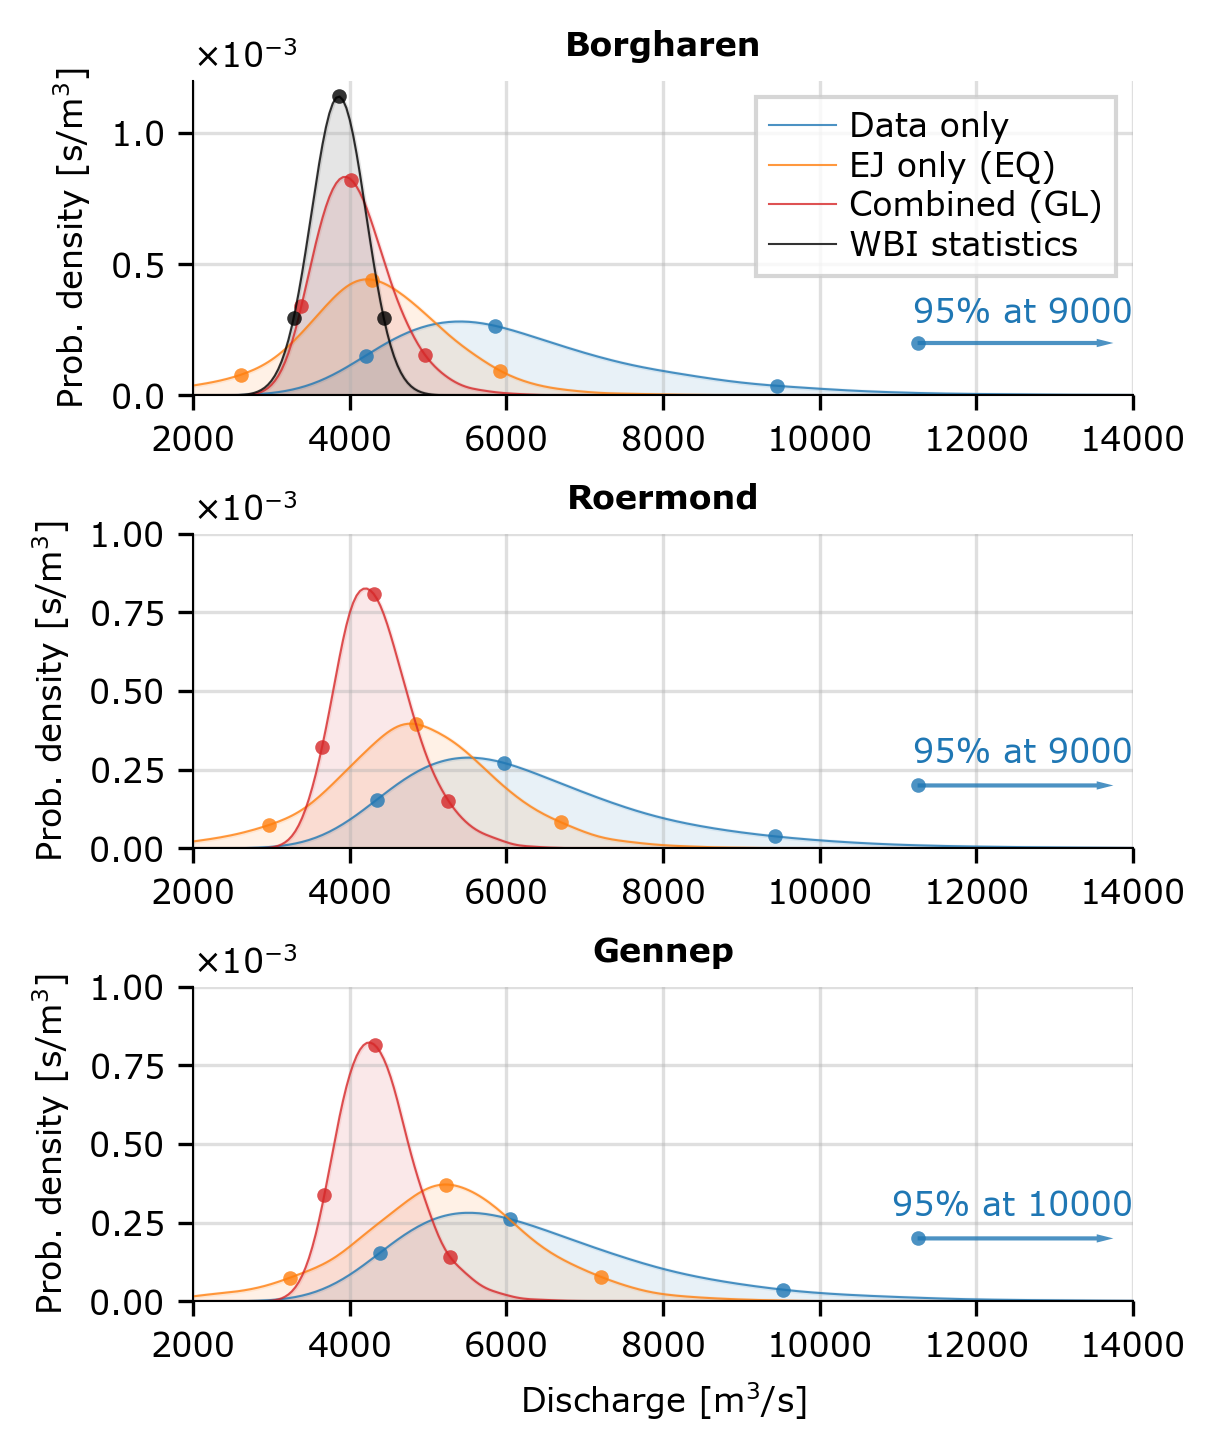

In [20]:
import matplotlib as mpl

plotargs = {
    "obs": dict(color="C0", lw=0.5, ls="-", alpha=0.8, label="Data only"),
    "ej": dict(color="C1", lw=0.5, ls="-", alpha=0.8, label="EJ only (EQ)"),
    "both": dict(color="C3", lw=0.5, ls="-", alpha=0.8, label="Combined (GL)"),
    "borgharen": dict(color="k", lw=0.5, ls="-", alpha=0.8, label="WBI statistics"),
}

# ### Borgharen data, EJ [EQ], Comb [GL]

fig, axs = plt.subplots(figsize=(10 / 2.54, 12 / 2.54), constrained_layout=True, nrows=3)

locations = ["Borgharen", "Roermond", "Gennep"]

modes = ["obs", "ej", "both"]
dms = [None, "EQ", "GL"]
xsteps = [500, 250, 150]


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


qgrid = np.linspace(1000, 14000, 300)

mf = mpl.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((1, 2))

rp = "T1000"

for location, ax in zip(locations, axs.T):

    for mode, dm, color, annotation, xstep in zip(modes, dms, colors, annotations, xsteps):

        col = np.load(
            directories["sampledir"] / location / rp / f"{mode}{'' if mode == 'obs' else '_'+dm}.npy"
        )

        ykde = kde_scipy(col, qgrid, xstep)
        ax.plot(qgrid, ykde, **plotargs[mode])
        ps = np.quantile(a=col, q=[0.05, 0.5, 0.95])
        ax.plot(
            ps,
            np.interp(ps, qgrid, ykde),
            marker=".",
            color=plotargs[mode]["color"],
            ls="",
            ms=7,
            alpha=0.8,
            mew=0,
        )
        ax.fill_between(x=qgrid, y1=ykde, alpha=0.1, color=plotargs[mode]["color"])

        ax.set(
            xlabel="Discharge [m$^3$/s]" if location == "Gennep" else "",
            ylabel="Prob. density [s/m$^3$]",
            xlim=(2000, 14000),
            ylim=(0, 0.001),
            title=location,
        )

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid()

        if mode == "obs":
            ax.text(
                14000,
                0.25e-3,
                f"95% at {round(ps[-1], -3):.0f}",
                color=plotargs[mode]["color"],
                ha="right",
                va="bottom",
            )
            ax.plot(11250, 0.2e-3, marker=".", color=plotargs[mode]["color"], ls="", ms=7, mew=0, alpha=0.8)
            ax.annotate(
                "",
                xytext=(11250, 0.2e-3),
                xy=(13750, 0.2e-3),
                arrowprops=dict(color="C0", width=1, headwidth=2, headlength=4, lw=0, alpha=0.8),
            )

        ax.yaxis.set_major_formatter(mf)

means = [3220, 3520, 3700, 3910]
Ts = [0.001666667, 0.000666667, 0.000333333, 0.000133333]
stds = [287.5, 285, 295, 350]
borgharen_mean = np.interp(np.log(0.001 / 6), np.log(Ts)[::-1], means[::-1])
borgharen_scale = np.interp(borgharen_mean, means, stds)
mode = "borgharen"
borgharen_norm = norm(loc=borgharen_mean, scale=350)
yborg = borgharen_norm.pdf(x=qgrid)
axs[0].plot(qgrid, yborg, **plotargs[mode])
axs[0].fill_between(x=qgrid, y1=yborg, alpha=0.1, color=plotargs[mode]["color"])
qs = [0.05, 0.5, 0.95]
ps = borgharen_norm.ppf(qs)
axs[0].plot(
    ps,
    borgharen_norm.pdf(ps),
    marker=".",
    color=plotargs[mode]["color"],
    ls="",
    ms=7,
    alpha=0.8,
    mew=0,
)
axs[0].set_ylim(0, 1.2e-3)
axs[0].legend()

# fig.savefig(directories["figuredir"] / f"{rp}discharges.pdf")